<a href="https://colab.research.google.com/github/yajuna/tensorflow_pde/blob/master/heat_pinn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas

from time import time
from IPython.display import clear_output

clear_output()

In [56]:
# set data type and hyperparameters

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE)

pi = tf.constant(np.pi, dtype = DTYPE)

# Set number of data points
N_0 = 412 # number of points in space; same as N_0 for simplicity
N_b = 412 # number of points in time; this is the amount of measurements in 24 hours
N_r = 1000

# Set boundary
tmin = 0.
tmax = 24.
xmin = 0.001
xmax = 0.135

# surface source to volume source
delta_r = (xmax - xmin) / N_b
coeff_surface = 1. / delta_r

# heat parameters
sigma = 5.76e-8
albedo = 0.3

# Lower bounds in time and space
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds in time and space
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data; need N_0 == N_b for concat
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_init = tf.linspace(lb[1], ub[1], N_0)
x_0 = tf.reshape(x_init, (N_0,1))
X_0 = tf.concat([t_0, x_0], axis=1)

# Boundary data- left to be core temperature, and right the bark temperature
t_boundary = tf.linspace(lb[0], ub[0], N_b)
t_b = tf.reshape(t_boundary, (N_b,1))
x_lb = tf.ones((N_b,1), dtype=DTYPE)*lb[1]
x_ub = tf.ones((N_b,1), dtype=DTYPE)*ub[1]
X_lb = tf.concat([t_b, x_lb], axis=1)
X_ub = tf.concat([t_b, x_ub], axis=1)

## Add extra training data at X_train (location at midTemp1)
idx = int(N_0 / 3)
x_train = tf.ones((N_0,1), dtype=DTYPE) * x_init[idx]
X_train = tf.concat([t_b, x_train], axis=1)
x_train1 = tf.ones((N_0,1), dtype=DTYPE) * x_init[2 * idx]
X_train1 = tf.concat([t_b, x_train1], axis=1)


# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

In [57]:
##### ave tree temp and weather temp for future reference
train_tree_temp_index = 416 - 2
train_interp_temp_size = train_tree_temp_index

train_weather_index = 145 - 2
train_interp_weather_size = train_weather_index

In [58]:
##### measured tree temperature for initial and boundary conditions. Need fixing
colnames_tree_temp = ['datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
url1 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Tree_Temp_Values_AUG21_to_AUG28_2022.xlsx"
dataTemp = pandas.read_excel(url1,names=colnames_tree_temp)

### training temperature data
# core temp is west, at 13.5cm, at 2m high
train_coreTemp = np.array(dataTemp.s135_3[2: train_tree_temp_index])#+ 273.15
# West, at 9cm, at 3m high
train_midTemp1 = np.array(dataTemp.w9_3[2: train_tree_temp_index])#+ 273.15
# North, at 4.5cm, at 3m high
train_midTemp2 = np.array(dataTemp.n45_3[2: train_tree_temp_index])#+ 273.15
# bark temp is West, at bark, at 3.5m high
train_barkTemp = np.array(dataTemp.w_ext_35[2: train_tree_temp_index])#+ 273.15

train_initTemp = np.array([train_coreTemp[0], train_midTemp1[0], train_midTemp2[0], train_barkTemp[0]])
train_init_temp = np.interp(np.linspace(0,xmax,N_0), np.linspace(0,xmax,train_initTemp.size),train_initTemp)


In [59]:
u_0 = train_init_temp
u_lb = train_coreTemp
u_ub = train_barkTemp
u_train = train_midTemp1
u_train1 = train_midTemp2

# collect initial and two boundary data in lists # add training data and points
X_data = [X_0, X_lb, X_ub ]#, X_train]#, X_train1]
u_data = [u_0, u_lb, u_ub ]#, u_train]#, u_train1]

In [60]:
colnames_weather = ['datetime', 'wind_speed', 'wind_direction', 'humidity', 'air_temperature', 'air_pressure', 'solar_DNI']
url2 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Weather_Station_AUG21_to_AUG28_2022.xlsx"
dataWeather = pandas.read_excel(url2,names=colnames_weather)

nu = 15.89e-6 # m^2/s kinematic viscosity of air
Pr = 0.707
ka = 26.3e-3 # W/mK conductivity of air
coeff = 2 * xmax / nu

#### training
# wind speed from Oct 21
train_windSpeed = np.array(dataWeather.wind_speed[:train_weather_index])
# humidity from Oct 21
train_humidity = np.array(dataWeather.humidity[:train_weather_index])
# air temperature from Oct 21
train_airTemp = np.array(dataWeather.air_temperature[:train_weather_index])#+ 273.15
# air pressure from Oct 21
train_airPressure = np.array(dataWeather.air_pressure[:train_weather_index])
# solar radiation from Oct 21
train_solar = np.array(dataWeather.solar_DNI[:train_weather_index])

train_airTemp = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,train_interp_weather_size),train_airTemp)
train_windSpeed = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,train_interp_weather_size),train_windSpeed)
train_solar = np.interp(np.linspace(0,24,N_b), np.linspace(0,24,train_interp_weather_size),train_solar)



Re_train = train_windSpeed * coeff
C_train = []
m_train = []
for j in range(train_windSpeed.size):
    temp = Re_train[j]
    if temp < 0.4:
        temp1 = [0, 0]
    if 0.4<=temp<= 4:
        temp1 = [0.989, 0.330]
    if 4<temp<= 40:
        temp1 = [0.911, 0.385]
    if 40<temp<= 4e3:
        temp1 = [0.683, 0.466]
    if 4e3<temp<= 4e4:
        temp1 = [0.193, 0.618]
    if 4e4<temp<= 4e5:
        temp1 = [0.027, 0.805]
    C_train.append(temp1[0])
    m_train.append(temp1[1])

Nu_train = C_train * Re_train ** m_train * Pr ** (1/3)
h_train = Nu_train * ka / (2 * xmax)

convect_train = h_train * (u_ub - train_airTemp)
sourceTerm_train = (1 - albedo) * train_solar + sigma * (train_airTemp**4 - u_ub**4) + convect_train


In [61]:
# lambd1 = 0.12/(1.38 * 510)
# lambd2 = 1./(1.38 * 510)

lambd1 = 0.12/(1380 * 510)
lambd2 = 1./(1380 * 510)

In [62]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))

    return model

In [63]:
def get_r(model, X_r)-> tf.Tensor:

    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
        u_t = tape.gradient(u, t)

    u_xx = tape.gradient(u_x, x)

    del tape

    return u_t - 1./x * lambd1 * u_x - lambd1 * u_xx - lambd2 * sourceTerm_train

In [64]:
model = init_model(num_hidden_layers = 2)
r = get_r(model, X_0)
phi_r = tf.reduce_mean(tf.square(r))
loss = phi_r

In [65]:
def compute_loss(model, X_r, X_data, u_data)-> tf.Tensor:

    # Compute phi^r-- physics informed loss
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))

    # Initialize loss
    loss = phi_r

    # Add initial error loss; add boundary loss

    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))

        return loss

    ## define customized loss-- max(abs(u_data and u_pred))


    return loss

In [66]:
loss = compute_loss(model, X_r, X_data, u_data)

In [67]:
def get_grad(model, X_r, X_data, u_data):

    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [68]:
# Initialize model aka u_\theta
model = init_model(num_hidden_layers = 2)
# print(model.layers[0].input_shape)

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [69]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step()-> tf.Tensor:
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)

    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))

    return loss

# Number of training epochs
EPOCH = 1000
hist = []

# Start timer
t0 = time()

for i in range(EPOCH+1):

    loss = train_step()

    # Append current loss to hist
    hist.append(loss.numpy())

    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 6.48393005e+02
It 00050: loss = 1.22172630e+02
It 00100: loss = 1.77519875e+01
It 00150: loss = 1.51656497e+00
It 00200: loss = 5.21427512e-01
It 00250: loss = 4.74709719e-01
It 00300: loss = 4.62031633e-01
It 00350: loss = 4.55243945e-01
It 00400: loss = 4.51074123e-01
It 00450: loss = 4.48289007e-01
It 00500: loss = 4.46317881e-01
It 00550: loss = 4.44861948e-01
It 00600: loss = 4.43750620e-01
It 00650: loss = 4.42879736e-01
It 00700: loss = 4.42182600e-01
It 00750: loss = 4.41614419e-01
It 00800: loss = 4.41144347e-01
It 00850: loss = 4.40750420e-01
It 00900: loss = 4.40416455e-01
It 00950: loss = 4.40130711e-01
It 01000: loss = 4.39883977e-01

Computation time: 6.562608003616333 seconds


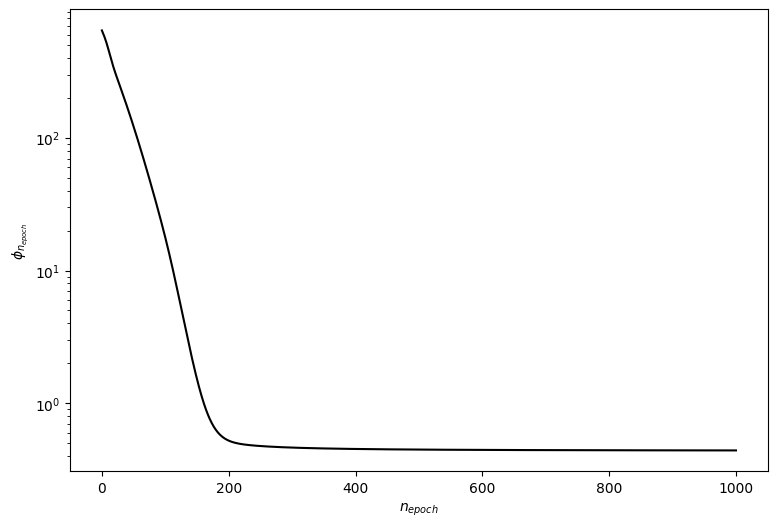

In [70]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$');